# Initialize

## Setup packages

In [1]:
!pip install netCDF4
!pip install basemap
!pip install torch
!pip install captum

In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
from pylab import meshgrid, colorbar
import torch
from sklearn.metrics import r2_score
from captum.attr import (
    IntegratedGradients, Saliency, NoiseTunnel,
    InputXGradient, LRP, Lime, KernelShap
)

## Settings

In [3]:
# Random seed
seed = 123
rng = np.random.default_rng(seed)
torch.manual_seed(seed)

# Prepare SST anomaly dataset

## Download SST data

This demo uses data from the [COBE SST2 and Sea-Ice](https://psl.noaa.gov/data/gridded/data.cobe2.html) dataset.

    Hirahara, S., Ishii, M., and Y. Fukuda, 2014: Centennial-scale sea surface 
    temperature analysis and its uncertainty. J of Climate, 27, 57-75. 
    http://journals.ametsoc.org/doi/pdf/10.1175/JCLI-D-12-00837.1 . 

In [4]:
# Monthly mean surface SST
url_monthly = "https://psl.noaa.gov/thredds/dodsC/Datasets/COBE2/sst.mon.mean.nc"
# Climatology monthly surface SST
url_climate = "https://psl.noaa.gov/thredds/dodsC/Datasets/COBE2/sst.mon.ltm.1981-2010.nc"

# Open NetCDF datasets
ds_sst_monthly = nc.Dataset(url_monthly)
ds_sst_climate = nc.Dataset(url_climate)

# Extract gridded data's latitude & longitude
lat = ds_sst_monthly["lat"][:]
print("Lat shape: ", lat.shape)
lon = ds_sst_monthly["lon"][:]
print("Lon shape: ", lon.shape)

# Extracted gridded monthly mean surface SST array, in parts because of size
sst_m_1 = np.array(ds_sst_monthly["sst"][:1020])   # Part 1
sst_m_2 = np.array(ds_sst_monthly["sst"][1020:])   # Part 2
sst_m = np.concatenate((sst_m_1, sst_m_2))         # Concatenate
print("SST shape: ", sst_m.shape)

# Extract gridded monthly climatology
sst_c = np.array(ds_sst_climate["sst"])
print("SST climatology shape", sst_c.shape)

# Convert months since 0 to between (1-12)
# That is, n2month(13) is month 1
def n2month(n):
    m = n % 12
    if m == 0:
        m = 12
    return m

Lat shape:  (180,)
Lon shape:  (360,)
SST shape:  (2040, 180, 360)
SST climatology shape (12, 180, 360)


## Calculate SST anomaly

In [5]:
# Tile the climatology for vectorized calculation of SST anomaly
monthsInYear = 12
nYears = sst_m.shape[0] / monthsInYear
sst_c_tiled = np.tile(sst_c, (int(nYears), 1,1))

# Ensure correct shapes
if (sst_c_tiled.shape != sst_m.shape):
    print("ERROR: Mismatch shape between operands!")
    raise

# Replace numeric invalid data flags with NAN
sst_m_ = np.copy(sst_m)
sst_m_ = np.where(np.greater(sst_m_, 1000), np.nan, sst_m_)
sst_c_tiled = np.copy(sst_c_tiled)
sst_c_tiled = np.where(np.less(sst_c_tiled, -1000), np.nan, sst_c_tiled)

# Calculate SST anomaly
sst_a = sst_m_ - sst_c_tiled

# Print value ranges to make sure they look reasonable
print("SST M:", np.nanmin(sst_m_), np.nanmax(sst_m_))
print("SST C:", np.nanmin(sst_c_tiled), np.nanmax(sst_c_tiled))
print("SST A:", np.nanmin(sst_a), np.nanmax(sst_a))

SST M: -3.0000002 34.378002
SST C: -1.9064999 33.221
SST A: -10.187901 6.092101


## Downsample SST anomaly

In [6]:
# Downsample

def bin_ndarray(ndarray, new_shape, operation='sum'):
    """
    Source: https://stackoverflow.com/a/29042041
    
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.

    Number of output dimensions must match number of input dimensions and 
        new axes must divide old ones.

    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)

    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]

    """
    operation = operation.lower()
    if not operation in ['sum', 'mean']:
        raise ValueError("Operation not supported.")
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d,c in zip(new_shape,
                                                  ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        op = getattr(ndarray, operation)
        ndarray = op(-1*(i+1))
    return ndarray

sst_a_small = np.array([bin_ndarray(arr, (18, 36), operation = "mean") for arr in sst_a])

## Plot SST data

Source: https://polar.ncep.noaa.gov/global/examples/usingpython.shtml 

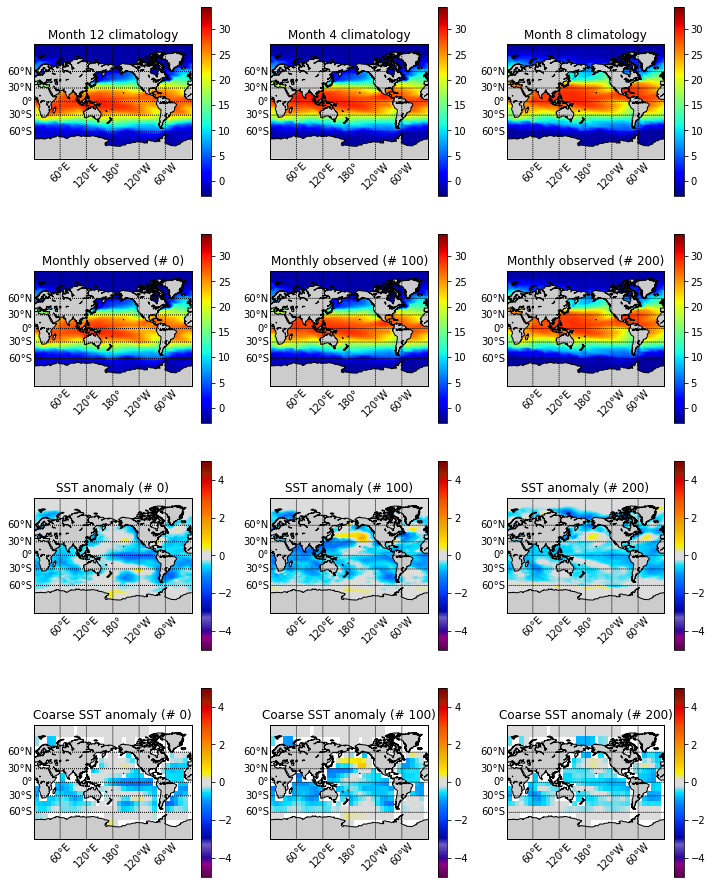

In [7]:
# Color pallete for SST anomaly
colors = ["#57004d", "#730069", "#910087", "#2c0699", "#4d32af", "#6b5ac3", "#0004a4", "#0014c0", "#0024dc", "#0043ff", "#005fff", "#007bff", "#00a5ff", "#00e1ff", "#dcdcdc", "#dcdcdc", "#f3f000", "#ffd200", "#f0be00", "#f0aa00", "#f09600", "#fd7800", "#f56400", "#ef5500", "#fb3000", "#eb1800", "#db0000", "#a02000", "#8a0f00", "#7d0400"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
cmap.set_over('#3c0000')
cmap.set_under('#28000a')

# Examples to plot
example_idxs = [0, 100, 200]
nExamples = len(example_idxs)

fig, axs = plt.subplots(4, 3, figsize=(12,16))
for i, e in enumerate(example_idxs):
    
    # Climatology
    vmin = min(np.nanmin(sst_m_), np.nanmin(sst_c_tiled))
    vmax = max(np.nanmax(sst_m_), np.nanmax(sst_c_tiled))
    data = sst_c_tiled[e]
    axs[0][i].title.set_text("Month {} climatology".format(n2month(e)))
    m = Basemap(projection='mill', lat_ts=10, \
            llcrnrlon=np.nanmin(lon), urcrnrlon=np.nanmax(lon), \
            llcrnrlat=lat.min(), urcrnrlat=lat.max(), \
            resolution='c', ax = axs[0][i])
    Lon, Lat = meshgrid(lon,lat)
    x, y = m(Lon,Lat)
    cs = m.pcolormesh(x,y,data,shading='auto', vmin=vmin, vmax=vmax, \
      cmap="jet")
    m.drawcoastlines();
    m.fillcontinents();
    m.drawmapboundary();
    m.drawparallels(np.arange(-90.,120.,30.), \
      labels=[1,0,0,0]);
    m.drawmeridians(np.arange(-180.,180.,60.), \
      labels=[0,0,0,1], rotation=45);
    colorbar(cs, ax = axs[0][i])
    
    # Observed 
    vmin = min(np.nanmin(sst_m_), np.nanmin(sst_c_tiled))
    vmax = max(np.nanmax(sst_m_), np.nanmax(sst_c_tiled))
    data = sst_m_[e]
    axs[1][i].title.set_text("Monthly observed (# {})".format(e))
    m = Basemap(projection='mill', lat_ts=10, \
            llcrnrlon=np.nanmin(lon), urcrnrlon=np.nanmax(lon), \
            llcrnrlat=lat.min(), urcrnrlat=lat.max(), \
            resolution='c', ax = axs[1][i])
    Lon, Lat = meshgrid(lon,lat)
    x, y = m(Lon,Lat)
    cs = m.pcolormesh(x,y,data,shading='auto', vmin=vmin, vmax=vmax, \
      cmap="jet")
    m.drawcoastlines();
    m.fillcontinents();
    m.drawmapboundary();
    m.drawparallels(np.arange(-90.,120.,30.), \
      labels=[1,0,0,0]);
    m.drawmeridians(np.arange(-180.,180.,60.), \
      labels=[0,0,0,1], rotation=45);
    colorbar(cs, ax = axs[1][i])
    
    # Anomaly
    vmin = -5
    vmax = 5
    data = sst_a[(e)]
    axs[2][i].title.set_text("SST anomaly (# {})".format(e))
    m = Basemap(projection='mill', lat_ts=10, \
            llcrnrlon=np.nanmin(lon), urcrnrlon=np.nanmax(lon), \
            llcrnrlat=lat.min(), urcrnrlat=lat.max(), \
            resolution='c', ax = axs[2][i])
    Lon, Lat = meshgrid(lon,lat)
    x, y = m(Lon,Lat)
    cs = m.pcolormesh(x,y,data,shading='auto', vmin=vmin, vmax=vmax, \
      cmap=cmap)
    m.drawcoastlines();
    m.fillcontinents();
    m.drawmapboundary();
    m.drawparallels(np.arange(-90.,120.,30.), \
      labels=[1,0,0,0]);
    m.drawmeridians(np.arange(-180.,180.,60.), \
      labels=[0,0,0,1], rotation=45);
    colorbar(cs, ax = axs[2][i]) 
    
    # Downsampled anomaly
    vmin = -5
    vmax = 5
    data = sst_a_small[(e)]
    axs[3][i].title.set_text("Coarse SST anomaly (# {})".format(e))
    m = Basemap(projection='mill', lat_ts=10, \
            llcrnrlon=np.nanmin(lon), urcrnrlon=np.nanmax(lon), \
            llcrnrlat=lat.min(), urcrnrlat=lat.max(), \
            resolution='c', ax = axs[3][i])
    lat_ = lat[::10]
    lon_ = lon[::10]
    Lon, Lat = meshgrid(lon_,lat_)
    x, y = m(Lon,Lat)
    cs = m.pcolormesh(x,y,data,shading='auto', vmin=vmin, vmax=vmax, \
      cmap=cmap)
    m.drawcoastlines();
    m.fillcontinents();
    m.drawmapboundary();
    m.drawparallels(np.arange(-90.,120.,30.), \
      labels=[1,0,0,0]);
    m.drawmeridians(np.arange(-180.,180.,60.), \
      labels=[0,0,0,1], rotation=45);
    colorbar(cs, ax = axs[3][i])     

# Create synthetic dataset

## Calculate correlation matrix from observation samples

In [8]:
# Reshape s.t. each 2D SST field is flattened 
sst = np.copy(sst_a_small)
sst_shape = sst.shape
print("Original shape: ", sst_shape)
sst_r = sst.reshape(sst_shape[0], sst_shape[1] * sst_shape[2])
print("New shape: ", sst_r.shape)

# Calculate correlation coef
sst_r_t = np.transpose(sst_r)
sst_cov = np.cov(sst_r_t)
sst_cov = np.nan_to_num(sst_cov, nan=0.0)

Original shape:  (2040, 18, 36)
New shape:  (2040, 648)


## Generate synthetic samples

In [9]:
nSamples = int(10e3)
samples_flat = rng.multivariate_normal(np.zeros(sst_cov.shape[0]), sst_cov, size = nSamples)
# Convert to 2D grid for plotting
samples_grid = samples_flat.reshape(nSamples, sst_shape[1], sst_shape[2])

# Define synthetic response function

In [10]:
# Samples
X = samples_flat
# Number of samples
N = X.shape[1]

## Generate piecewise linear functions

In [11]:
# Number of segments of the piecewise functions
K = 5

# Generate piecewise coeffs
B = np.transpose(rng.multivariate_normal(np.zeros(sst_cov.shape[0]), sst_cov, size = K-1))
# B = np.random.rand(N, K - 1)
print(B.shape)

# Generate bounds
x_min = np.nanmin(X)
x_max = np.nanmax(X)
boundaries = np.linspace(x_min, x_max, K)
print(boundaries)

# Generate conditions
nFunc = len(boundaries) - 1
C = np.zeros((nFunc, X.shape[0], X.shape[1]))
for i in range(nFunc):
    C[i] = np.logical_and(X > boundaries[i],  X <= boundaries[i + 1])
    
# Linear function
def f(x, b):
    return x * b

# Piecewise linear function
def pf_cell(X, C, B):
    return np.piecewise(X, C, [lambda x=x, b=b: f(x, b) for b in B])
                            
# Piecewise linear function at each cell
def pf_cells(X, C, B):
    return np.transpose(np.array([pf_cell(X[:,i], C[:,:,i], B[i]) for i in range(X.shape[1])]))

(648, 4)
[-3.00991143 -1.45872549  0.09246044  1.64364638  3.19483232]


## Combine to form additive separable function 

In [12]:
# Linearly separable sum of cell-wise piecewise functions
def F(X, C, B):
    return np.sum(pf_cells(X, C, B), axis=1)

## Demonstrate functions

In [13]:
# Test the functions
print("Samples (X) shape: ", X.shape)
print("Conditions (C) shape: ", C.shape)
print("Piecewise coeffs (B) shape: ", B.shape)
print("")

print("Single evaluation of a linear function:")
x = X[0,0]  #(sample, cell)
b = B[0,2]  #(cell, piece)
y = f(x, b)
print("f({}, {}) = {}".format(x, b, y))
print("")

print("Evaluate piecewise linear function at a single cell:")
x = X[0,0]
c = C[:,0,0]
b = B[0,:]
print("x = {}".format(x))
print("boundaries = {}".format(boundaries))
print("c = {}".format(c))
print("b = {}".format(b))
y = pf_cell(x, c, b)
print("y = {}".format(y))
print("")

print("Evaluate piecewise linear function at all cells:")
attribution = pf_cells(X, C, B)
print("Output shape: ", attribution.shape)
print("")

print("Evaluate F(sample):")
y_values = F(X, C, B)
print("Output shape:", y.shape)

Samples (X) shape:  (10000, 648)
Conditions (C) shape:  (4, 10000, 648)
Piecewise coeffs (B) shape:  (648, 4)

Single evaluation of a linear function:
f(0.14158203001660757, -0.17449285633948033) = -0.024705052823939897

Evaluate piecewise linear function at a single cell:
x = 0.14158203001660757
boundaries = [-3.00991143 -1.45872549  0.09246044  1.64364638  3.19483232]
c = [0. 0. 1. 0.]
b = [ 0.15867959  0.07799099 -0.17449286  0.01683057]
y = -0.024705052823939897

Evaluate piecewise linear function at all cells:
Output shape:  (10000, 648)

Evaluate F(sample):
Output shape: ()


## Attribution ground truth

In [14]:
attr = attribution
attr_grid = attribution.reshape(nSamples, sst_shape[1], sst_shape[2])
attrMax = np.nanmax(attr_grid)
attrMin = np.nanmin(attr_grid)

## Plot synthetic data & attribution

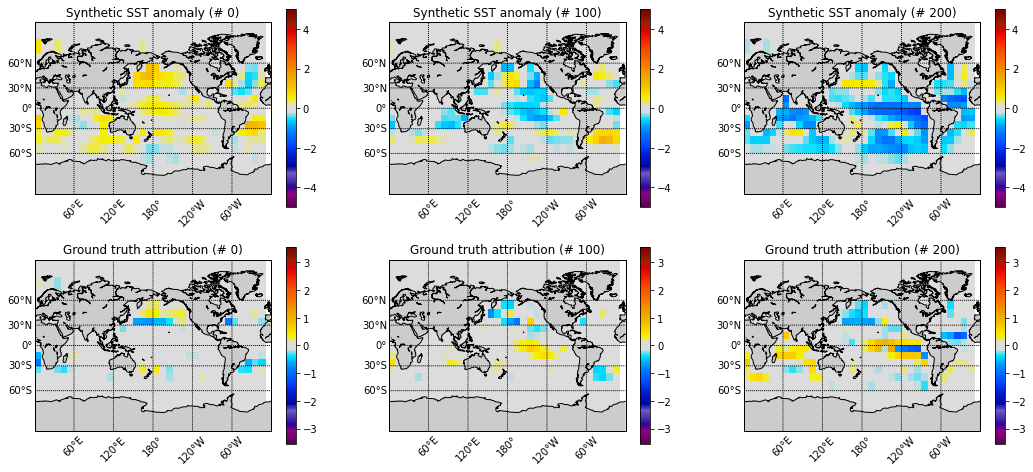

In [15]:
# Examples to plot
example_idxs = [0, 100, 200]
nExamples = len(example_idxs)

fig, axs = plt.subplots(2, 3, figsize=(18,8))
for i, e in enumerate(example_idxs):
    
    # Downsampled anomaly
    vmin = -5
    vmax = 5
    data = samples_grid[(e)]
    axs[0][i].title.set_text("Synthetic SST anomaly (# {})".format(e))
    m = Basemap(projection='mill', lat_ts=10, \
            llcrnrlon=np.nanmin(lon), urcrnrlon=np.nanmax(lon), \
            llcrnrlat=lat.min(), urcrnrlat=lat.max(), \
            resolution='c', ax = axs[0][i])
    lat_ = lat[::10]
    lon_ = lon[::10]
    Lon, Lat = meshgrid(lon_,lat_)
    x, y = m(Lon,Lat)
    cs = m.pcolormesh(x,y,data,shading='auto', vmin=vmin, vmax=vmax, \
      cmap=cmap)
    m.drawcoastlines();
    m.fillcontinents();
    m.drawmapboundary();
    m.drawparallels(np.arange(-90.,120.,30.), \
      labels=[1,0,0,0]);
    m.drawmeridians(np.arange(-180.,180.,60.), \
      labels=[0,0,0,1], rotation=45);
    colorbar(cs, ax = axs[0][i])
    
    # Attribution
    vmax = max(abs(attrMin), abs(attrMax))
    vmin = -vmax
    data = attr_grid[(e)]
    
    axs[1][i].title.set_text("Ground truth attribution (# {})".format(e))
    m = Basemap(projection='mill', lat_ts=10, \
            llcrnrlon=np.nanmin(lon), urcrnrlon=np.nanmax(lon), \
            llcrnrlat=lat.min(), urcrnrlat=lat.max(), \
            resolution='c', ax = axs[1][i])
    lat_ = lat[::10]
    lon_ = lon[::10]
    Lon, Lat = meshgrid(lon_,lat_)
    x, y = m(Lon,Lat)
    cs = m.pcolormesh(x,y,data,shading='auto', vmin=vmin, vmax=vmax, \
      cmap=cmap)
    m.drawcoastlines();
    m.fillcontinents();
    m.drawmapboundary();
    m.drawparallels(np.arange(-90.,120.,30.), \
      labels=[1,0,0,0]);
    m.drawmeridians(np.arange(-180.,180.,60.), \
      labels=[0,0,0,1], rotation=45);
    colorbar(cs, ax = axs[1][i])

# Approximate F with deep learning model

## Architecture

In [16]:
class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = [512, 256, 64, 32, 16]
        self.nHidden = len(self.hidden_sizes)
        # First layer
        self.input_layer = torch.nn.Linear(self.input_size, self.hidden_sizes[0])
        self.relu = torch.nn.ReLU()
        # Hidden layers
        self.hidden_layers = [
            torch.nn.Linear(self.hidden_sizes[i], self.hidden_sizes[i + 1]) \
            for i in range(self.nHidden - 1)]
        # Output layer
        self.output_layer = torch.nn.Linear(self.hidden_sizes[self.nHidden - 1], 1)
        
    def forward(self, x):
        layer1 = self.input_layer(x)
        relu = self.relu(layer1)
        for hidden_layer in self.hidden_layers:
            hl = hidden_layer(relu)
            relu = self.relu(hl)
        y = self.output_layer(relu)
        return y

## Setup data

In [17]:
nTrain = int(7e3)
x_train = torch.FloatTensor(X[0:nTrain])
y_train = torch.FloatTensor(y_values[0:nTrain])
input_len = x_train.shape[1]

x_test = torch.FloatTensor(X[nTrain:])
y_test = torch.FloatTensor(y_values[nTrain:])

## Initialize model

In [18]:
input_size = x_train.shape[1]
model = MLP(input_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [19]:
model.eval()
y_pred = model(x_test)
before_train = criterion(y_pred.squeeze(), y_test)
print('Test loss before training' , before_train.item())

Test loss before training 56.22560501098633


## Train model

In [ ]:
model.train()
epoch = int(10e3)
printEvery = 500
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(x_train)
    # Compute loss
    loss = criterion(y_pred.squeeze(), y_train)
    if (epoch % 500 == 0):
      print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()

## Calculate metrics

In [34]:
y_pred_train = y_pred.detach().numpy()
r2_train = r2_score(y_true=y_train, y_pred=y_pred_train)
print("Training R2 score = {}".format(r2_train))

model.eval()
y_pred_test = model(x_test).detach().numpy()
r2_test = r2_score(y_true=y_test, y_pred=y_pred_test)
print("Testing R2 score = {}".format(r2_test))

Training R2 score = 0.9319716512562819
Testing R2 score = 0.9025538731527151


# XAI

In [75]:
example_idxs = [0, 100]
x_xai = x_train[example_idxs]
y_pred_xai = torch.FloatTensor(y_pred_train[example_idxs].squeeze())
if len(x_xai.shape) == 1:
    x_xai = x_xai.unsqueeze(0)
nSamples = x_xai.shape[0]
print("XAI samples shape: ", x.shape)
print("      preds shape: ", y_pred_xai.shape)

XAI samples shape:  (18, 36)
      preds shape:  torch.Size([2])


### Gradient (a.k.a. saliency map)

In [76]:
sm = Saliency(model)
attr_saliencyMap = sm.attribute(x_xai, abs = False)
attr_saliencyMap_grid = attr_saliencyMap.reshape(nSamples, sst_shape[1], sst_shape[2])

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


### Smooth Gradient

In [62]:
sg = NoiseTunnel(sm)
attr_smoothGrad = sg.attribute(x_xai, nt_type="smoothgrad", abs = False)
attr_smoothGrad_grid = attr_smoothGrad.reshape(nSamples, sst_shape[1], sst_shape[2])

### Integrated gradients

In [63]:
ig = IntegratedGradients(model)
attr_inputTimeGrad = ig.attribute(x_xai)#, baseline, target=0, return_convergence_delta=True)
attr_inputTimeGrad_grid = attr_inputTimeGrad.reshape(nSamples, sst_shape[1], sst_shape[2])

### Input X gradient

In [64]:
ixg = InputXGradient(model)
attr_inputXGrad = ixg.attribute(x_xai).detach().numpy()
attr_inputXGrad_grid = attr_inputXGrad.reshape(nSamples, sst_shape[1], sst_shape[2])

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


### LRP_z

In [65]:
lrpz = LRP(model)
attr_lrpz = lrpz.attribute(x_xai).detach().numpy()
attr_lrpz_grid = attr_lrpz.reshape(nSamples, sst_shape[1], sst_shape[2])

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


### LIME

In [66]:
lime = Lime(model)
attr_lime = lime.attribute(x_xai, n_samples=1000).detach().numpy()
attr_lime_grid = attr_lime.reshape(nSamples, sst_shape[1], sst_shape[2])

/usr/local/lib/python3.7/dist-packages/captum/attr/_core/lime.py:1111: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  "You are providing multiple inputs for Lime / Kernel SHAP "


### KernelSHAP

In [67]:
kshap = KernelShap(model)
attr_kshap = kshap.attribute(x_xai, n_samples=10000).detach().numpy()
attr_kshap_grid = attr_kshap.reshape(nSamples, sst_shape[1], sst_shape[2])

/usr/local/lib/python3.7/dist-packages/captum/attr/_core/lime.py:1111: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  "You are providing multiple inputs for Lime / Kernel SHAP "


## Plot XAI attributions

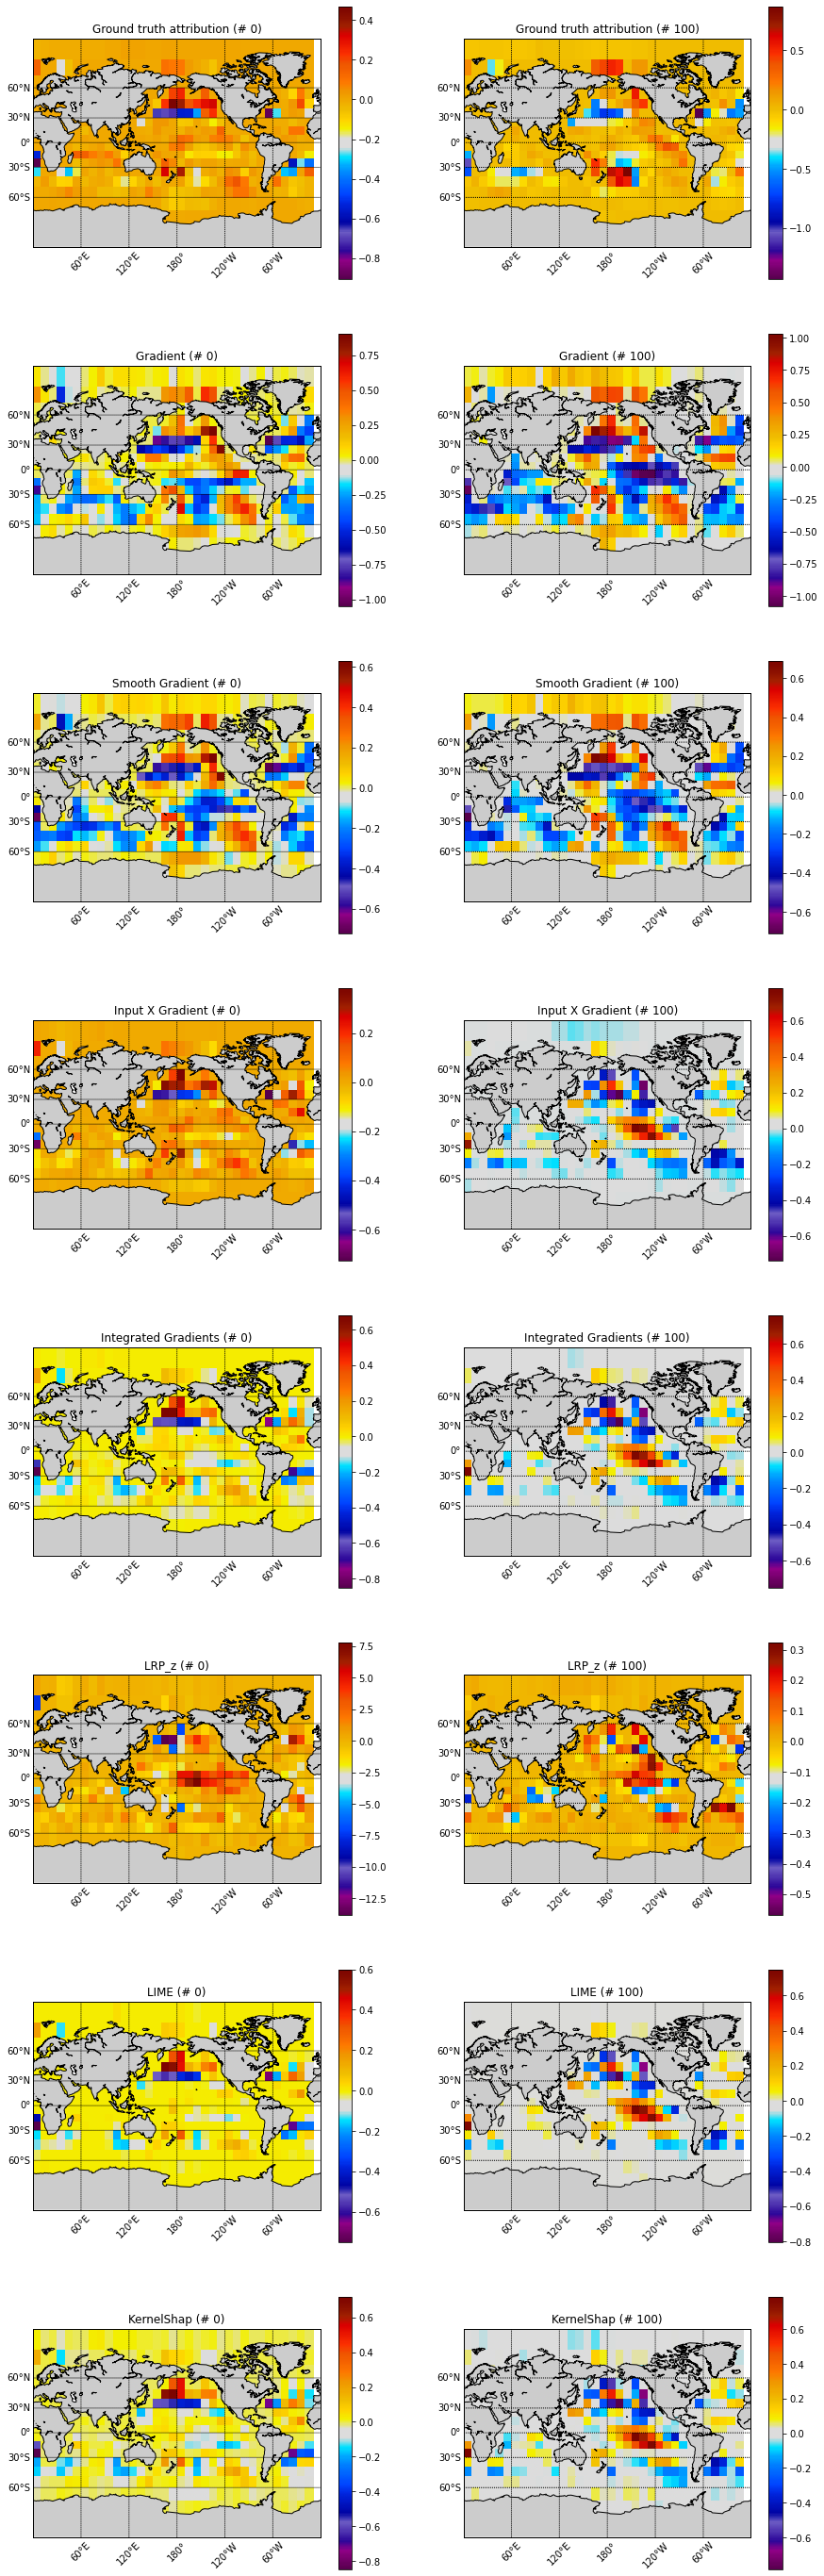

In [86]:
nExamples = len(example_idxs)
nPlot = min(nSamples, 3)   # Print at most 3

def plotAttrib(dataset, index, title, ax):
    # Colorbar limits
    # vmax = max(abs(np.nanmax(dataset)), abs(np.nanmin(dataset)))
    # vmin = -vmax
    # Selected sample
    data = dataset[(index)]
    # Plot title
    ax.title.set_text(title)
    # Geospatial basemap
    m = Basemap(projection='mill', lat_ts=10, \
            llcrnrlon=np.nanmin(lon), urcrnrlon=np.nanmax(lon), \
            llcrnrlat=lat.min(), urcrnrlat=lat.max(), \
            resolution='c', ax = ax)
    lat_ = lat[::10]
    lon_ = lon[::10]
    Lon, Lat = meshgrid(lon_,lat_)
    x, y = m(Lon,Lat)
    # Plot data
    cs = m.pcolormesh(x,y,data,shading='auto',  #, vmin=vmin, vmax=vmax, 
      cmap=cmap)
    # Plot geospatial chart elements
    m.drawcoastlines();
    m.fillcontinents();
    m.drawmapboundary();
    m.drawparallels(np.arange(-90.,120.,30.), \
      labels=[1,0,0,0]);
    m.drawmeridians(np.arange(-180.,180.,60.), \
      labels=[0,0,0,1], rotation=45);
    colorbar(cs, ax = ax)    
    
fig, axs = plt.subplots(8, nPlot, figsize=(15,50))
for i, e in enumerate(example_idxs):
    plotAttrib(attr_grid, i, "Ground truth attribution (# {})".format(e), ax=axs[0][i])
    plotAttrib(attr_saliencyMap_grid, i, "Gradient (# {})".format(e), ax=axs[1][i])
    plotAttrib(attr_smoothGrad_grid, i, "Smooth Gradient (# {})".format(e), ax=axs[2][i])
    plotAttrib(attr_inputXGrad_grid, i, "Input X Gradient (# {})".format(e), ax=axs[3][i])
    plotAttrib(attr_inputTimeGrad_grid, i, "Integrated Gradients (# {})".format(e), ax=axs[4][i])
    plotAttrib(attr_lrpz_grid, i, "LRP_z (# {})".format(e), ax=axs[5][i])
    plotAttrib(attr_lime_grid, i, "LIME (# {})".format(e), ax=axs[6][i])
    plotAttrib(attr_kshap_grid, i, "KernelShap (# {})".format(e), ax=axs[7][i])